## Welcome to BQuant
<img style="float:left;" src="workflow.png" width="500" height="500" />

In [1]:
# Import the BQL library
import bql
import pandas as pd

# Instantiate an object to interface with the BQL service
bq = bql.Service()

### BQL (String) Query Here

In [2]:
# Define the request string
request = """
let(
#NAV=fund_net_asset_val().Value;
#px=PX_LAST().Value;
#premium=(100)*(#px -#NAV)/#NAV;
#max_discount=MIN(#premium);
#rank=grouprank(-#max_discount).Value;
#AUM=last(dropNA(FUND_TOTAL_ASSETS().Value));
#current_=LAST(dropna(#premium)).Value;
#volume=matches(px_volume,#premium==min(#premium));
#name =groupsort(long_comp_name,sortby=#max_discount,order=asc).Value;
)

get(
   #name,
   #current_,
   #max_discount,
   #volume().date+0d as #Max_Discount_Date,
   #volume().Value as #volume_, 
   #AUM,
   PARENT_COMP_NAME as #Issuer
)


for(filter(
   filter(
   fundsuniv(['active','primary']), 
   FUND_TYP == 'ETF' AND EXCH_CODE == 'US' AND 
   #aum > 75M AND 
   FUND_STRATEGY == 'Municipal'), 
#rank <= '50')
)

with(dates=range(-6M,0D), currency=USD)

"""

#### Execute Query

In [3]:
# Execute the request
response = bq.execute(request)

In [4]:
# Display the response in a DataFrame
newdf1 = bql.combined_df(response)
#newdf1.sample(n=20)

In [5]:
#pd.write_excel()

### Display as a sortable Table

In [6]:
from bqwidgets import DataGrid

newdf1.reset_index(inplace=True)

In [7]:
dg = DataGrid(data=newdf1)
dg

DataGrid(column_defs=[{'headerName': 'ID', 'field': 'ID', 'filter': 'text', 'width': 100}, {'headerName': '#na…

### Interactive Scatter Chart

In [8]:
import bqviz as bqv

bqv.InteractiveScatterPlot(newdf1).show()

In [10]:
import seaborn as sns

### Pairplot (seaborn)

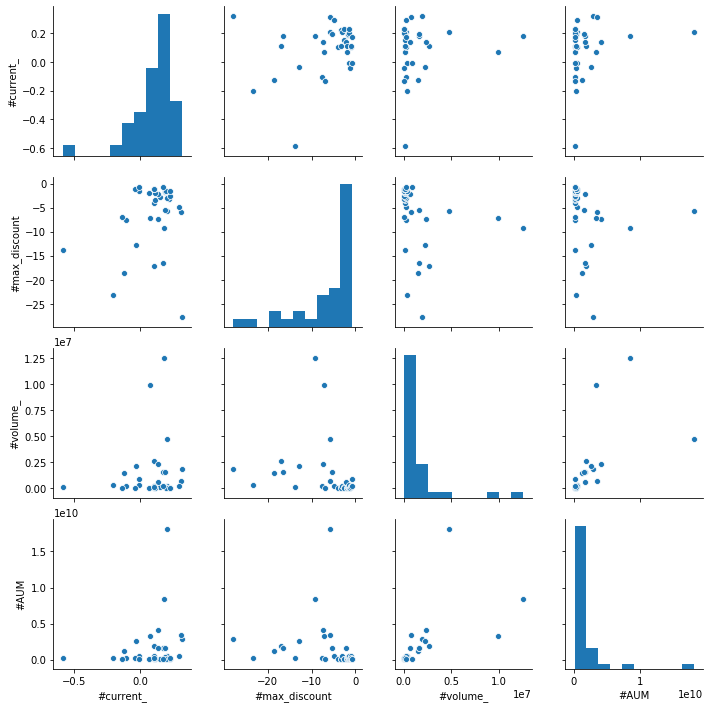

In [11]:
sns.pairplot(newdf1)

### Historgram (pandas)

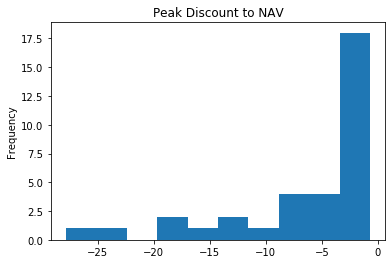

In [11]:
newdf1['#max_discount'].plot.hist(title='Peak Discount to NAV')

### Box and Whiskers (seaborn) 

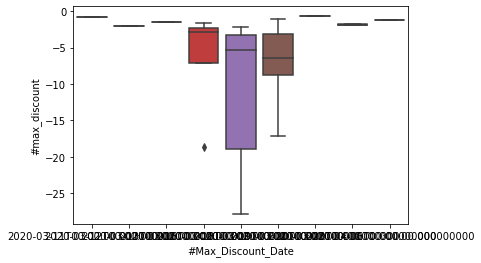

In [12]:
sns.boxplot(x='#Max_Discount_Date', y='#max_discount',data=newdf1)

### Regression (seaborn)

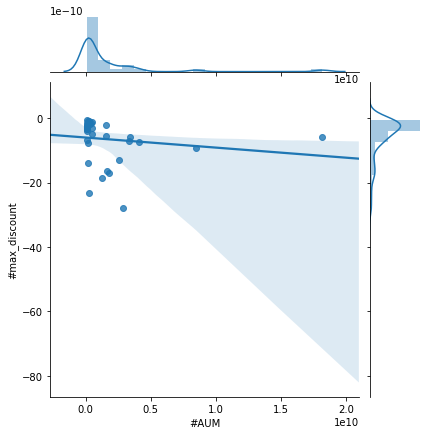

In [13]:
sns.jointplot('#AUM', '#max_discount', data=newdf1, kind='reg', truncate=False)

### Bloomberg-style boxplot

In [ ]:
styles = {
        'axes.edgecolor': '.8',
        'axes.facecolor': '#111111',
        'axes.labelcolor': 'white',
        'figure.facecolor': '#111111',
        'grid.color': '#444444',
        'grid.linestyle': '--',
        'patch.linewidth': 1.0,
        'figure.facecolor': '#111111',
        'font.family': ['Arial', 'Helvetica', 'sans-serif'],
        'patch.force_edgecolor': True,
        'text.color': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'lines.color': 'r'}

sns.set_style(styles)

In [ ]:
sns.pairplot(data=newdf1, dropna=True, kind='reg')

## 

In [ ]:
import numpy as np
from bqplot import *
import pandas as pd

In [ ]:
# Create some random data to work with
np.random.seed(0)
rows = ['Y Category {}'.format(i+1) for i in range(6)]
columns = ['X Category {}'.format(i+1) for i in range(15)]
dataframe = pd.DataFrame(np.random.randn(6,15), index=rows, columns=columns)

# Create the scales
scale_color = ColorScale(colors=['#FF1E3E', '#1a1a1a', '#30C030'])
scale_x = OrdinalScale(allow_padding=False)
scale_y = OrdinalScale(allow_padding=False)

In [ ]:
dataframe

In [ ]:
newdf1.head()

In [ ]:
# Create the grid heat map
mark_grid_map = GridHeatMap(color=dataframe,
                            scales={'color': scale_color,
                                    'row':scale_y,
                                    'column':scale_x},
                            row=dataframe.index,
                            column=dataframe.columns)

# Add the text labels
label_df = pd.melt(dataframe.reset_index(), id_vars='index')
mark_label = Label(x=label_df[label_df.columns[1]],
                  y=label_df[label_df.columns[0]],
                  text=['{0:.2f}'.format(val)
                        for val in label_df[label_df.columns[2]]],
                  align='middle',
                  font_weight='normal',
                  default_size=12,
                  colors=['white'],
                  scales={'x': scale_x, 'y':scale_y})

# Create the axes
axis_y = Axis(scale=scale_y,orientation='vertical')
axis_x = Axis(scale=scale_x,
              tick_style={'text-anchor': 'start'},
              tick_rotate=25)

# Create the figure
visualization = Figure(marks=[mark_grid_map, mark_label],
                       axes=[axis_y, axis_x],
                       padding_y=0.0,
                       fig_margin={'top': 50, 'bottom':60,
                                   'left':100, 'right':80},
                       layout={'width': 'auto', 'height': '400px'},
                       title_style={'fill': 'white', 'font-size': '18'},
                       title='Basic heatmap with values')

def update_plot(new_df):
    """This function will update the plot when provided a new dataframe."""

    mark_grid_map.color = new_df
    mark_grid_map.row = new_df.index
    mark_grid_map.column = new_df.columns
    new_label_df = pd.melt(new_df.reset_index(), id_vars='index')
    mark_label.x = new_label_df[new_label_df.columns[1]]
    mark_label.y = new_label_df[new_label_df.columns[0]]
    mark_label.text = ['{0:.2f}'.format(val)
                       for val in new_label_df[new_label_df.columns[2]]]

visualization

## Make Interactive Chart via `bqplot`

In [ ]:
dataframe = newdf1

#### Code copied from Visualizaiton Gallery

In [ ]:
import bqplot as bqp
from bqplot.interacts import BrushSelector
import pandas as pd
import numpy as np
from ipywidgets import Dropdown, HBox, VBox, HTML
import bqwidgets as bqw


# Create scales
scale_x = bqp.LinearScale()
scale_y = bqp.LinearScale()

# Create marks
mark_scatter = bqp.Scatter(x=dataframe[dataframe.columns[3]],
                           y=dataframe[dataframe.columns[4]],
                           scales={'x': scale_x, 'y': scale_y},
                           default_size=48,
                           colors=['#1B84ED'])

# Create Axes
axis_x = bqp.Axis(scale=scale_x, label=dataframe.columns[3])
axis_y = bqp.Axis(scale=scale_y,
                  orientation='vertical',
                  tick_format='0.0f',
                  label=dataframe.columns[4])

# Create selector
selector = BrushSelector(x_scale=scale_x,
                         y_scale=scale_y,
                         marks=[mark_scatter])

# Create Figure
figure = bqp.Figure(marks=[mark_scatter],
                    axes=[axis_x, axis_y],
                    animation_duration=500,
                    layout={'width':'99%', 'height':'400px'},
                    padding_x=0.05,
                    title='Interactive scatter plot with linked datagrid',
                    title_style={'font-size': '22px'},
                    padding_y=0.05,
                    interaction=selector,
                    fig_margin={'top': 50, 'bottom': 60,
                                'left': 50, 'right':30})

# Create dropown widgets
dropdown_x = Dropdown(description='X axis',
                      options=dataframe.columns,
                      value=dataframe.columns[3])
dropdown_y = Dropdown(description='Y axis',
                      options=dataframe.columns,
                      value=dataframe.columns[4])

# Define callback function for dropdown widgets
def update_plot(evt):
    if evt is not None:
        new_value = evt['new']
        if evt['owner'] == dropdown_x:
            mark_scatter.x = dataframe[new_value]
            axis_x.label = new_value
        elif evt['owner'] == dropdown_y:
            mark_scatter.y = dataframe[new_value]
            axis_y.label = new_value


# Define callback function for selections
def on_select(evt):
    if evt is not None and evt['new'] is not None:
        indices = evt['new']
        datagrid.data = dataframe.iloc[indices].reset_index()

# Bind callback to the dropdown widgets
dropdown_x.observe(update_plot, names=['value'])
dropdown_y.observe(update_plot, names=['value'])
mark_scatter.observe(on_select, names=['selected'])

# Create datagrid
datagrid = bqw.DataGrid(data=dataframe, layout={'height': '300px'})

# Create Box containers
widget_box = HBox([dropdown_x, dropdown_y], layout={'margin': '10px'})
app_container = VBox([figure, widget_box, datagrid],
                     layout={'width':'100%'})

In [ ]:
# **Display the visualization**
app_container

## Picker


In [ ]:
import ipywidgets as widgets


In [ ]:
issuer_picker = widgets.Dropdown(options=newdf1['#Issuer'])

In [ ]:
issuer_picker

In [ ]:
import ipywidgets as ipw
import bqplot as bqp
import pandas as pd
import numpy as np

In [ ]:
# Generate some data to work with
np.random.seed(0)
id1 = ['Security 1']*9 + ['Security 2']*9 + ['Security 3']*9
id2 = ['Index C']*9 + ['Index B']*9 + ['Index A']*9
cat1 = ['Period {}'.format(n+1) for n in range(9)]*3
cat2 = ['Category {}'.format(chr(n)) for n in range(65+9, 65,-1)]*3
dataframe = pd.DataFrame(data={'ID 1': id1,
                               'ID 2': id2,
                               'Category 1': cat1,
                               'Category 2': cat2,
                               'Value 1': np.random.randn(27),
                               'Value 2': np.random.randn(27)})

dataframe.head()

In [ ]:
df_demo = dataframe
newdf1.head()

In [ ]:
# Columns that will appear in the dropdown widgets
X_COLUMNS = ['ID 1', 'ID 2']
Y_COLUMNS = ['Category 1', 'Category 2']
VALUE_COLUMNS = ['Value 1', 'Value 2']

# We need to reshape the data to create our plot
processed_dataframe = dataframe.pivot(index=Y_COLUMNS[0],
                                      columns=X_COLUMNS[0],
                                      values=VALUE_COLUMNS[0])
processed_dataframe

In [ ]:
label_df = pd.melt(processed_dataframe.reset_index(),
                   id_vars=[Y_COLUMNS[0]],
                   value_name=VALUE_COLUMNS[0])

# Create scales
scale_color = bqp.ColorScale(colors=['#FF1E3E', '#1a1a1a', '#30C030'])
scale_x = bqp.OrdinalScale()
scale_y = bqp.OrdinalScale()

# Create axes
axis_x = bqp.Axis(orientation='horizontal',
                  scale=scale_x,
                  label=X_COLUMNS[0],
                  grid_lines='none',
                  label_offset='3em')

axis_y = bqp.Axis(orientation='vertical',
                  scale=scale_y,
                  label=Y_COLUMNS[0],
                  grid_lines='none',
                  label_offset='6em')

# Create mark
grid_map = bqp.GridHeatMap(color=processed_dataframe,
                           row=processed_dataframe.index.astype(str),
                           column=processed_dataframe.columns,
                           scales={'color': scale_color,
                                   'row': scale_y,
                                   'column': scale_x},
                           font_style={'font-size': '12px',
                                       'fill':'black',
                                       'font-weight': 'bold'},
                           interactions={'click': 'select'},
                           selected_style={'stroke': '#ffffff',
                                           'stroke-width': 2},
                           opacity=1,
                           stroke='#626262')

mark_label = bqp.Label(x=label_df[X_COLUMNS[0]],
                       y=label_df[Y_COLUMNS[0]],
                       text=['{0:.3f}'.format(val)
                            for val in label_df[VALUE_COLUMNS[0]]],
                       scales={'x': scale_x, 'y': scale_y},
                       colors=['white'],
                       default_size=14,
                       font_weight='normal',
                       align='middle')

# Create figure
figure = bqp.Figure(marks=[grid_map, mark_label],
                    axes=[axis_x, axis_y],
                    title='Interactive heat map with labels',
                    title_style={'font-size': '22px'},
                    layout={'width':'auto', 'height': '500px'},
                    fig_margin={'top': 50, 'bottom': 75,
                                'left': 120, 'right': 50},
                    padding_y=0.0,
                    padding_x=0.0)

# HTML widget to display selection
html = ipw.HTML()

# Dropdown widgets
dropdown_x = ipw.Dropdown(description='X axis',
                          options=X_COLUMNS,
                          value=X_COLUMNS[0])
dropdown_y = ipw.Dropdown(description='Y axis',
                          options=Y_COLUMNS,
                          value=Y_COLUMNS[0])
dropdown_value = ipw.Dropdown(description='Value',
                              options=VALUE_COLUMNS,
                              value=VALUE_COLUMNS[0])

# Callback functions
def handle_selection(self, evt):
    html.value = 'Clicked on: {}'.format(evt['data'])

def update_plot(evt=None):
    if evt['new'] is not None:
        processed_dataframe = dataframe.pivot(index=dropdown_y.value,
                                              columns=dropdown_x.value,
                                              values=dropdown_value.value)

        label_df = pd.melt(processed_dataframe.reset_index(),
                   id_vars=[dropdown_y.value],
                   value_name=dropdown_value.value)

        grid_map.color = processed_dataframe
        grid_map.column = processed_dataframe.columns
        grid_map.row = processed_dataframe.index
        axis_x.label = dropdown_x.value
        axis_y.label = dropdown_y.value
        mark_label.x = label_df[dropdown_x.value]
        mark_label.y = label_df[dropdown_y.value]
        mark_label.text = ['{0:.3f}'.format(val)
                          for val in label_df[dropdown_value.value]]

# Event handlers for heatmap clicks and dropdown updates
grid_map.on_element_click(handle_selection)
dropdown_x.observe(update_plot, names=['value'])
dropdown_y.observe(update_plot, names=['value'])
dropdown_value.observe(update_plot, names=['value'])

# Display the figure
ipw.VBox([figure,
          ipw.HBox([dropdown_x, dropdown_y, dropdown_value]),
          html])